In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import os

plt.rcParams['figure.figsize'] = [12, 8]
c = [
    "#66c2a5",
    "#fc8d62",
    "#8da0cb",
    "#e78ac3",
    "#a6d854",
    "#ffd92f",
    "#e5c494",
    "#b3b3b3",
]  # Set2
sns.set(
    style="ticks",
    rc={
        "font.family": "Liberation Sans",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 3,
    },
    font_scale=2.5,
    palette=sns.color_palette("Set2")
)

In [18]:
def create_histograms(traces):
    hists = []
    for trace in traces:
        counts, _ = np.histogram(trace, bins=128, range=(-7, -0.5))
        hists.append(counts)
    hists = np.array(hists)
    return hists

def truncate_trace(trace, threshold = -7):
    condition = trace < threshold
    counts = np.cumsum(condition)
    idx = np.searchsorted(counts, 3)
    trace = trace[:idx]

    return trace

interpolation_length = 2500
def load_traces(traces):
    raw_traces = []
    interpolated_traces = []
    for trace in tqdm(traces):
        if len(trace) > 10000:
            trace = trace[10000:]
        if len(trace) > 2000:
            continue
        thresh = np.argmax(trace <= -.5)
        trace = trace[thresh:]
        trace = truncate_trace(trace, threshold=-6)
        raw_traces.append(trace)

        # Interpolate traces
        from scipy.interpolate import interp1d
        f = interp1d(
            np.linspace(0, len(trace), num=len(trace), endpoint=True), trace
        )
        xnew = np.linspace(
            0, len(trace), num=interpolation_length, endpoint=True
        )
        interpolated_traces.append(f(xnew))
    raw_traces = np.array(raw_traces)
    interpolated_traces = np.array(interpolated_traces)

    hists = create_histograms(raw_traces)

    return hists, raw_traces, interpolated_traces

def plot_data(traces, labels, ax=None, use_labels=True, show_original=True):
    if ax is None:
        _, ax = plt.subplots()

    counts, binedges = np.histogram(traces, bins=100, range=(-7, -0.5))
    binedges = (binedges[1:] + binedges[:-1])/2
    ax.plot(
        binedges,
        counts/len(traces),
        label=f"Original" if show_original else "",
        c="k",
        linestyle="--",
        alpha=0.8,
    )

    for label in np.unique(labels):
        plot_traces = traces[labels == label]
        counts, binedges = np.histogram(plot_traces, bins=100, range=(-7, -0.5))
        binedges = (binedges[1:] + binedges[:-1])/2
        ax.plot(
            binedges,
            counts/len(traces),
            label=f"{label}: {len(plot_traces)}" if use_labels else "",
            c=c[int(label) % len(c)]
        )
        if use_labels:
            ax.legend(frameon=False)

In [20]:
# Load molecule
raw_traces = np.load("./clustering_data.npy", allow_pickle=True)
hists, traces, interp = load_traces(raw_traces)

100%|██████████| 7651/7651 [00:01<00:00, 6275.43it/s]
/tmp/ipykernel_10650/2680513553.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  raw_traces = np.array(raw_traces)


In [15]:
from scipy.cluster.hierarchy import linkage

metrics = ["Euclidean", "Cityblock", "Cosine"]
method = "complete"
for metric in tqdm(metrics):
    Z = linkage(hists, method=method, metric=metric)
    np.save(f"./Z_{method}_{metric}.npy", Z)

100%|██████████| 3/3 [00:11<00:00,  3.73s/it]


100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


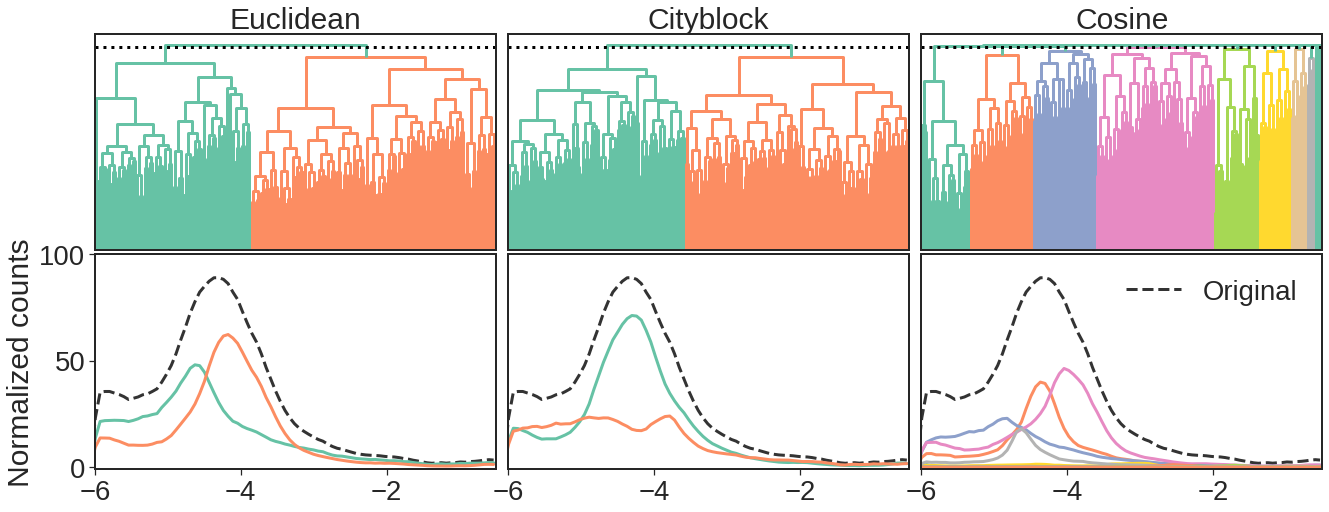

In [17]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

fig, axes = plt.subplots(2, 3, figsize=(22, 8))
hierarchy.set_link_color_palette(c)

metrics = ["Euclidean", "Cityblock", "Cosine"]
method = "complete"
a = []
for idx, (metric, ax) in enumerate(tqdm(zip(metrics, axes.T), total=len(metrics))):
    Z = np.load(f"./Z_{method}_{metric}.npy")
    color_threshold = 0.99*np.max(Z[:, 2])
    dn = dendrogram(Z, ax=ax[0], no_labels=True, p=7, truncate_mode="level", color_threshold=color_threshold)
    ax[0].axes.get_yaxis().set_visible(False)
    ax[0].axhline(color_threshold, linestyle="dotted", c="k")
    ax[0].set_title(f"{metric}")

    plt.subplots_adjust(wspace=0.03, hspace=0.02)

    clusters = fcluster(Z, color_threshold, criterion="distance")
    a.append(clusters)
    plot_data(interp, clusters - np.min(clusters), ax[1], use_labels=False, show_original=True)
    if idx > 0:
        ax[1].axes.get_yaxis().set_visible(False)
    else:
        ax[1].set_ylabel("Normalized counts")
    ax[1].set_xlim(-6, -.5)
    ax[1].set_ylim(-1, 100)
    start, end = ax[1].get_xlim()
    new_ticks = np.arange(start, end, 2)
    ax[1].xaxis.set_ticks(new_ticks)

ax[1].legend(frameon=False)
# fig.savefig("./dendrogram_2d_09.pdf")